# STA 208: Homework 2 (Do not distribute)

## Due 5/2/2018 in class and online by 10am

__Instructions:__ To make grading easier for the TAs please print out your homework and also submit it on canvas.  The canvas should include all of your code either in this notebook file, or a separate python file that is imported and ran in this notebook.  We should be able to open this notebook and run everything here by running the cells in sequence.  The written portions can be either done in markdown and TeX in new cells or written clearly by hand when you hand it in.

- Code should be well organized and documented
- All math should be clear and make sense sequentially
- When in doubt explain what is going on
- You will be graded on correctness of your math, code efficiency and succinctness, and conclusions and modelling decisions

__Exercise 1__ (30 pts)

Consider Poisson model with rate parameter $\lambda$ which has PMF,
$$
p(y|\lambda) = \frac{\lambda^y}{y!} e^{-\lambda},
$$
where $y = 0,1,\ldots$ is some count variable.
In Poison regression, we model $\lambda = e^{\beta^\top x}$ to obtain $p(y | x,\beta)$.

1. Let the loss function for Poisson regression be $\ell_i(\beta) \propto - \log p(y_i | x_i, \beta)$ for a dataset consisting of predictor variables and count values $\{x_i,y_i\}_{i=1}^n$.  Here $\propto$ means that we disregard any additive terms that are not dependent on $\beta$.  Write an expression for $\ell_i$ and derive its gradient. 
2. Show that the empirical risk $R_n(\beta)$ is a convex function of $\beta$.
3. Consider the mapping $F_\eta(\beta) = \beta - \eta \nabla R_n(\beta)$ which is the iteration of gradient descent ($\eta>0$ is called the learning parameter).  Show that at the minimizer of $R_n$, $\hat \beta$, we have that $F(\hat \beta) = \hat \beta$.
4. I have a script to simulate from this model below.  Implement the gradient descent algorithm above and show that with enough data (n large enough) the estimated $\hat \beta$ approaches the true $\beta$ (you can look at the sum of square error between these two vectors).

In [34]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
## Simulate from the Poisson regression model (use y,X)
n, p = 1000,20
X = np.random.normal(0,1,size = (n,p))
beta = np.random.normal(0,.2,size = (p))
lamb = np.exp(X @ beta)
y = np.random.poisson(lamb)

In [36]:
# gradient descent
beta_0 = np.zeros(p)
beta_new = np.zeros(p)
itrtn = np.arange(1, 21)*100
error = []
learning_rate = .001

# create the error list for different n
for i in range(len(itrtn)):
    iterations = 0
    beta_before = beta_0
    gradient = 1/X.shape[0]*(-X.T@y + X.T@np.exp(X@beta_0))
    while iterations < itrtn[i]:
        beta_new = beta_before - learning_rate*gradient
        beta_before = beta_new
        gradient = 1/X.shape[0]*(-X.T@y + X.T@np.exp(X@beta_new))
        iterations += 1
    error.append(sum((beta_new-beta)**2))

Text(0.5,1,'error for different iterations')

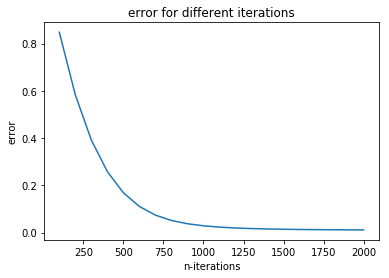

In [37]:
plt.plot(itrtn, error)
plt.xlabel('n-iterations')
plt.ylabel('error')
plt.title("error for different iterations")

For Answers of __$Exercise 1$__'s $ 1,2,3$, please check the last page.

$4$. From the above plot, it is obvious that when the iterations $n$ is increasing, the error between the estimated $\hat \beta$ and the true $\beta$ is decreasing, which proves that the estimated $\hat \beta$ approaches the true $\beta$.

__Exercise 2__ (30 pts)

Recall the subset selection problem with tuning parameter $k$,
$$
\min_{\beta : {\rm supp}(\beta) \le k}\| y - X_S \beta_S \|_2^2.
$$

1. Write the subset selection problem in the following form
$$
\min_{S \subseteq \{1,\ldots,p\}, |S|\le k} y^\top P_S y,
$$
where $P_S$ is a projection.  Describe the subspace that is the range of this projection.
2. Suppose that we have a nested sequence of models $S_1\subset S_2 \subset \ldots \subset S_p$ such that $|S_k| = k$ (it contains $k$ variables).  Prove that $$y^\top P_{S_k} y \ge y^\top P_{S_{k+1}} y$$ for $k=1,\ldots,p-1$.  What does this tell us about the solution to the subset selection problem and the constraint $|S| \le k$?
3. Suppose that $X$ is orthogonal, then write a computationally efficient pseudocode to solve the subset selection problem.  Prove that it is correct (your algorithm actually solves subset selection under othogonal design).
4. Suppose that we have that $n = p$ and $y_i = \beta_i + \epsilon_i$ (identity design matrix) where $\epsilon_i$ satisfies 
$$
\mathbb P \left\{ |\epsilon_i| \ge t \right\} \le 2 e^{-t^2 / 2\sigma^2}
$$
for any $t > 0$ (this is true for central Normal RVs) for some $\sigma > 0$.
Suppose that there is some true $S_0 \subset\{1,\ldots,p\}$ such that $|S_0| = k < p$ and ${\rm supp}(\beta) = S_0$.
Prove the following.

__Proposition__
Define $\mu = \min_{j \in S_0} |\beta_j|$ and call $\mu / \sigma$ the signal-to-noise ratio.  Then if 
$$
\frac{\mu}{\sigma} > 2 \sqrt{2 \log \left( \frac{2n}{\delta}\right)},
$$
then the true $S$ is selected by subset selection with probability at least $1 - \delta$.

Hint: rewrite the subset selection problem with $X = I$ and compare the objective at $S_0$ to any other $S$.

__Solution__:

Please check the last page of the homework.

__Exercise 3__ (40 pts)
For this exercise, it may be helpful to use the `sklearn.linear_model` module.  I have also included a plotting tool for making the lasso path in ESL.

1. Load the training and test data using the script below.  Fit OLS on the training dataset and compute the test error.  Throughout you do not need to compute an intercept but you should normalize the X (divide by the column norms).
2. Train and tune ridge regression and compute the test error (square error loss).
3. Fit the lasso path to the data and compute the test error for each returned lasso coefficient.
4. Compare and contrast the lars path to the lasso path, what is the key difference.  Tell me when the active sets differ and how, if they do at all.
4. Extract each active set from the lasso path and recompute the restricted OLS for each.  Compute and compare the test error for each model.
5. If your boss said that they wanted a more parsimonious model (a smaller model) then which model would you choose, justify your answer.  Under which circumstance would you choose the model with the smallest test error.

In [38]:
def plot_lars(coefs, lines=False, title="Lars Path"):
    """
    Plot the lasso path where coefs is a matrix - the columns are beta vectors
    """
    xx = np.sum(np.abs(coefs.T), axis=1)
    xx /= xx[-1]
    plt.plot(xx, coefs.T)
    ymin, ymax = plt.ylim()
    if lines:
        plt.vlines(xx, ymin, ymax, linestyle='dashed')
    plt.xlabel('|coef| / max|coef|')
    plt.ylabel('Coefficients')
    plt.title(title)
    plt.axis('tight')

In [39]:
import pickle
with open('hw2.data','rb') as f:
    y_tr,X_tr,y_te,X_te = pickle.load(f)

In [40]:
import pandas as pd
import numpy as np

from sklearn import linear_model, neighbors
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression, lars_path, Lasso, LassoCV, Ridge, RidgeCV

In [41]:
from sklearn.preprocessing import normalize
X_tr = normalize(X_tr,axis = 0)
X_te = normalize(X_te,axis = 0)

In [42]:
def test_error(fit,true):
    return sum((fit-true)**2)/len(true)

$1$. The following is the fitted OLS Regression and the __test error__ is $1.0411444900270803$.

In [43]:
# fit the OLS on the training dataset
lin = linear_model.LinearRegression(fit_intercept=False)
lin.fit(X_tr,y_tr)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [44]:
y_OLS_test = lin.predict(X_te)

# test error
test_error(y_OLS_test,y_te)

1.0411444900270803

$2$. The following is the fitted Ridge Regression and the __test error__ is $1.0395797450591562$.

In [45]:
# Ridge Regression
alphas = 10**np.linspace(10,-2,100)*0.5
rcv = RidgeCV(alphas = alphas,cv=None, store_cv_values=True)
rcv.fit(X_tr,y_tr)
#cv_vals = rcv.cv_values_

RidgeCV(alphas=array([5.00000e+09, 3.78232e+09, ..., 6.60971e-03, 5.00000e-03]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=True)

In [46]:
rcv.alpha_

0.005

In [47]:
y_Ridge_test = rcv.predict(X_te)

#test error
test_error(y_Ridge_test,y_te)

1.0395797450591562

$3$. The following is the fitted Lasso path. From the graph _'test error for returned lasso coefficient'_, it shows that the test error is increasing while the returned lasso coefficients is increasing.

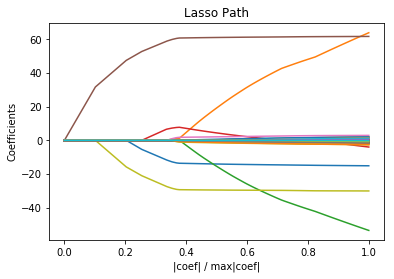

In [48]:
# Lasso path
alphas_lasso, active_lasso, coefs_lasso = lars_path(X_tr,y_tr,method='lasso')
plot_lars(coefs_lasso,title="Lasso Path")

In [49]:
test_error_lasso = []
for i in range(coefs_lasso.shape[1]):
    fit = X_tr@coefs_lasso.T[i]
    error = test_error(fit,y_tr)
    test_error_lasso.append(error)

Text(0.5,1,'test error for returned lasso coefficient')

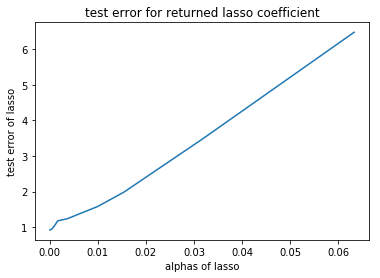

In [55]:
plt.plot(alphas_lasso, test_error_lasso)
plt.xlabel('alphas of lasso')
plt.ylabel('test error of lasso')
plt.title("test error for returned lasso coefficient")

$4$. The following is the fitted Lars Path. 

Based on the graphs of Lasso Path and Lars Path, they looks to be roughly identical and both of them shows that the first 6 variables are very significant. The most obvious difference is the fourth variable (red line), in the Lars Path, it is dropped earlier compared with that in the Lasso Path and it is also included again with a more significant weight later.

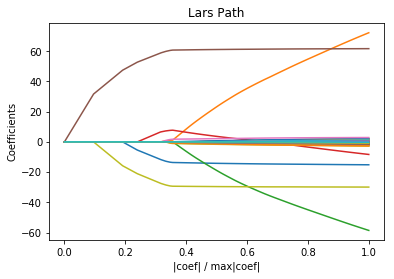

In [51]:
# lars path
alphas_larsalphas_l , active_lars, coefs_lars = lars_path(X_tr,y_tr,method = 'lars')
plot_lars(coefs_lars)

In [52]:
lasso_active_error = []

for i in range(len(active_lasso)):
    chosen = active_lasso[:i+1]
    X = X_tr[:,chosen]
    lin.fit(X,y_tr)
    
    y_OLS_test = lin.predict(X_te[:,chosen])
    # test error
    error = test_error(y_OLS_test,y_te)
    lasso_active_error.append(error)

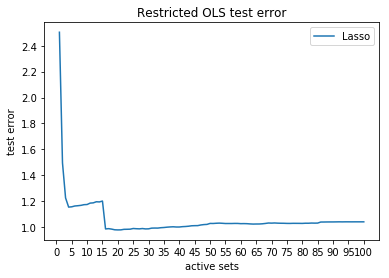

In [68]:
active_sets = list(range(1,len(active_lasso)+1))
plt.plot(active_sets,lasso_active_error, label = 'Lasso')
plt.xlabel('active sets')
plt.ylabel('test error')
plt.xticks(np.arange(0, 101, 5))
plt.title('Restricted OLS test error');
plt.legend()
plt.show()

$5$. From the above graph, obviously we can conclude that as the active sets increases, the restricted OLS test error is steeply decreasing at the beginnig, and slightly increases from $5$ to $14$, then it hits the minimum OLS test error when $15$ active sets are selected, after that it starts to slightly increase again.

$6$. Based on the graph, for smaller variance, when we choose the first $4$ active sets, the OLS test error shows the model is adequate enough. Therefore, I would choose the first $4$ variables from the active sets.

When I have a big sample size ($n$ is large), and collecting data from those variables are not very costy, I would prefer to choose the model with the smallest test error.